# Wikipedia Articles NLP Project

## Overview

This notebook performs an NLP on random articles collected from [Wikipedia](https://en.wikipedia.org/). It explored different feature extraction and clustering methods.

## Imports

In [28]:
import gensim.downloader as model_api
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import time
import torch

## Data Collection

In [2]:
url = 'https://en.wikipedia.org/w/api.php'
#csv_path = 'data/wiki_articles.csv'
csv_path = 'wiki_articles.csv'

In [ ]:
def get_random_titles(n:int) -> np.array:
    titles = []
    while len(titles) < n:
        try:
            params = {
                'action': 'query',
                'list': 'random',
                'rnnamespace': 0,  # Only articles
                'rnlimit': min(50, n - len(titles)),
                'format': 'json'
            }
            response = requests.get(url, params=params)
            data = response.json()
            batch = [item['title'] for item in data['query']['random']]
            titles.extend(batch)
            time.sleep(0.5)
        except Exception as e:
            print('Error:', e)
            time.sleep(1)
    return np.array(titles)

In [ ]:
def get_article_text(title:str) -> str:
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'extracts',
        'explaintext': True,
        'titles': title
    }
    try:
        response = requests.get(url, params=params)
        pages = response.json()['query']['pages']
        page = next(iter(pages.values()))
        return page.get('extract', '')
    except Exception as e:
        print(f'Error fetching {title}: {e}')
        return ''

In [ ]:
def remove_unwanted_sections(text):
    unwanted_sections = [
        r'==\s*See also\s*==',
        r'==\s*References\s*==',
        r'==\s*Further reading\s*==',
        r'==\s*External links\s*==',
        r'==\s*Notes\s*==',
        r'==\s*Sources\s*==',
        r'==\s*Bibliography\s*==',
        r'==\s*Footnotes\s*=='
    ]

    pattern = re.compile('|'.join(unwanted_sections), re.IGNORECASE)
    match = pattern.search(text)

    if match:
        return text[:match.start()].strip()
    else:
        return text.strip()

In [ ]:
def full_clean(text):
    core = remove_unwanted_sections(text)
    core = re.sub(r'\n{2,}', '\n', core)
    return core.strip()

In [ ]:
def export_list_to_csv(data:list[dict], csv_path:str) -> None:
	df = pd.DataFrame(data)
	if not os.path.isfile(csv_path):
		df.to_csv(csv_path, index=False)
	else:
		df.to_csv(csv_path, index=False, header=False, mode='a')

In [ ]:
# Get 10000 random articles from Wikipedia
titles = get_random_titles(10000)
chunks = np.array_split(titles, 100)

In [ ]:
# Export data in chunks
for i, chunk in enumerate(chunks):
	print(f'Chunk {i + 1}/{len(chunks)}')
	wiki_list = []
	for title in chunk:
		text = get_article_text(title)
		if text and len(text) > 300:  # Filter out very short pages
			wiki_list.append({
				'title': title,
				'text': full_clean(text)
			})
		time.sleep(0.5) # Sleep for 500 ms to avoid rate-limiting
	export_list_to_csv(wiki_list, csv_path)
	print(f'Added {len(wiki_list)}/{len(chunk)} articles to CSV file.')

## EDA

In [4]:
# Load data
df = pd.read_csv(csv_path)
df.head()

,title,text
0,Biff Schlitzer,"Victor Joseph ""Biff"" Schlitzer (December 4, 18..."
1,Prabhash Kumar,"Prabhash Kumar is an Indian politician, farmer..."
2,San Carlos Formation,The San Carlos Formation is a geological forma...
3,2023 in Ohio,The following is a list of events of the year ...
4,2009 Iowa special elections,The 2009 Iowa state special elections were hel...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8595 non-null   object
 1   text    8595 non-null   object
dtypes: object(2)
memory usage: 134.4+ KB


In [7]:
# Get smallest text
index = df['text'].str.len().idxmin()
df.iloc[index]

,5992
title,List of volcanoes in El Salvador
text,This is a list of active and extinct volcanoes...


In [5]:
# Get biggest text
index = df['text'].str.len().idxmax()
df.iloc[index]

,5321
title,Divided differences
text,"In mathematics, divided differences is an algo..."


## Data Preprocessing

### GloVe

In [8]:
# Tokenize texts by removing punctuation and special characters
# and lowercasing everything
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['text'].str.replace(pattern, replacer, regex=True).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [9]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [10]:
# Function to retrieve the word vector or return a zero vector if the word is not found
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

# Function to map a text to its vector representation by summing the word vectors
def map_text_to_vector(page):
    return np.sum([get_word_vector(word) for word in page if pd.notna(word)], axis=0)

# Apply the mapping function to each text and create a DataFrame of the results
glove_emb = pd.DataFrame(words.apply(map_text_to_vector, axis=1).tolist())
glove_emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-25.553197,61.277992,-6.441907,-1.327819,33.129767,25.303264,-93.681521,-16.925939,-39.743567,-34.605831,...,-31.948293,-17.013292,7.921901,-10.060203,-43.326178,41.130120,-28.867548,-40.196636,-8.029011,-6.774925
1,1.704619,-1.517041,-13.325157,5.417937,20.572402,23.046139,-10.669863,-4.731333,-16.040038,-24.081318,...,-27.581619,14.695299,-22.071071,-11.928519,-20.945080,10.538783,-21.423375,-22.582989,19.028705,-20.659330
2,17.696770,2.319915,-2.985669,5.802332,11.713197,3.547520,-16.159113,-15.404687,-11.138138,-3.644905,...,-26.690475,-17.304464,2.805483,2.516293,0.250916,5.042878,6.546632,-9.455825,2.516218,-19.384553
3,57.877136,42.455009,17.792969,-2.447541,9.637690,54.997059,-98.312935,5.448763,0.324308,-72.113289,...,-66.280624,-2.030703,29.818583,-25.870623,-49.491760,43.662933,-53.715706,-36.119362,10.410617,-42.222218
4,4.474286,20.002575,7.467521,10.103029,37.283440,48.269833,-125.686661,-12.588920,-42.947601,-100.732811,...,-80.048775,35.040638,-52.696964,-45.672440,-89.739273,49.484070,-88.131134,-34.871624,8.551754,27.011698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,14.352584,122.384755,-170.521032,-47.543207,33.140047,40.247651,-144.909884,17.184558,-138.784235,-16.838819,...,-45.112582,18.165843,-47.235383,-89.321172,-80.017884,43.918467,-65.476791,-84.576976,-123.467156,-24.511413
8591,186.930886,-73.040578,-125.070949,37.098090,223.528212,191.890156,-199.127123,-234.222369,-46.272845,37.687762,...,22.619779,59.103097,-3.399424,27.933238,331.744119,261.918040,-57.953918,-41.787180,-38.495136,-91.641842
8592,15.554881,26.999107,-32.302677,-13.859942,20.643557,-5.603209,-58.670879,-1.185496,-48.660622,-19.573153,...,-22.711718,4.816690,-11.640561,-36.836224,-58.727997,22.536022,-32.802155,-52.557323,16.080572,-19.773840
8593,53.355042,-24.083059,-6.758219,-5.503126,61.069004,32.600834,-51.542694,7.272554,-10.884201,-61.907169,...,-72.853905,36.391407,35.984333,-12.220505,-5.377378,25.349607,-92.599640,-37.820564,24.898485,-86.716850


### all-MiniLM-L6-v2

In [11]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# Calculate embeddings
mini_emb = pd.DataFrame(model.encode(df['text']))
mini_emb

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.023374,0.023269,-0.103945,-0.033877,0.031884,0.100352,-0.051282,0.155663,-0.035584,0.051362,...,-0.053423,-0.014926,-0.045564,-0.063073,0.016583,-0.078675,0.018316,-0.048807,-0.053580,-0.006450
1,0.001867,-0.012857,-0.052250,-0.035741,0.041092,0.021050,0.093268,-0.023004,-0.087791,0.028738,...,-0.052659,0.017524,-0.082142,-0.061607,-0.000720,0.023933,0.108369,0.060540,-0.015630,-0.011093
2,-0.051594,0.027089,-0.045995,0.067701,-0.045514,-0.002171,-0.086146,-0.015811,-0.035470,-0.026100,...,0.005135,0.006779,0.050991,0.040364,-0.004147,0.011562,-0.047039,0.027455,0.086669,-0.001813
3,-0.006973,0.010959,0.037496,0.016119,0.095530,0.044021,-0.007896,0.041771,-0.131271,0.058207,...,0.041905,0.019995,-0.004059,-0.129669,0.002306,-0.022474,-0.031808,0.017117,0.007192,0.009654
4,-0.046682,-0.012143,0.086666,-0.046343,0.007200,0.052154,-0.024122,0.040913,0.006559,0.040980,...,-0.044681,-0.068946,-0.053276,-0.181910,0.004719,0.064600,0.025116,0.041235,0.016052,-0.075555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,0.008887,0.017314,-0.041147,-0.014189,-0.073766,0.079026,-0.019779,0.052027,-0.037399,0.011336,...,0.018744,-0.022396,-0.025683,0.030633,0.007230,-0.019306,0.007542,0.079803,-0.048633,-0.000934
8591,-0.013043,-0.084558,-0.066673,0.016100,0.024330,-0.031969,0.008016,-0.021110,0.055534,-0.042198,...,-0.031272,0.039986,0.023300,-0.063697,0.106172,-0.044735,-0.046021,0.077347,0.082478,0.018576
8592,0.056743,-0.016630,-0.045755,0.021144,-0.031342,-0.050017,-0.061236,0.062345,0.089322,-0.009769,...,-0.092888,0.007519,0.099991,0.052765,0.022278,0.003323,-0.021144,-0.013760,-0.052189,-0.044215
8593,0.059751,0.089780,-0.048822,0.020530,0.057927,0.023562,0.012857,0.002716,0.015486,0.049756,...,0.021733,0.056091,0.006063,-0.078170,0.012723,-0.022446,0.086766,-0.044068,0.004002,-0.003946


### msmarco-distilbert-base-v3

In [13]:
# Load models
model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v3')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
# Calculate embeddings
bert_emb = pd.DataFrame(model.encode(df['text']))
bert_emb

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.222106,-0.142562,-0.486214,-0.050806,-0.671452,-0.647942,0.050960,-0.339348,-0.658761,-0.233152,...,-0.304564,-0.288950,0.012745,-0.081978,0.246320,0.526322,-0.555079,0.176017,-0.236318,-0.718464
1,-0.737513,0.033536,0.218303,-0.454655,-0.368240,0.957529,0.370220,-0.627844,-0.120924,0.286784,...,-0.490203,0.054526,0.452170,0.521633,-0.007956,0.804411,-0.464803,-0.016429,-0.452164,-0.182953
2,0.235789,1.021756,0.039773,-0.382134,0.394749,0.309669,-0.024793,0.436277,0.457114,-0.150869,...,0.436135,0.736471,-0.202076,-0.271993,-0.355585,0.099346,-0.257547,-0.520932,0.329737,0.383017
3,-0.531803,-0.458048,-0.129811,0.475163,0.041470,-0.409742,0.135139,0.334338,0.260772,0.387352,...,-0.113359,0.587746,0.456869,0.100298,0.827325,0.127599,0.293117,-1.172684,-0.134510,-0.554411
4,-0.950702,-0.312903,-0.757418,0.680520,-0.497849,0.576880,0.287248,-0.491700,-0.522242,0.286487,...,-0.421967,0.135190,0.024186,-0.031755,0.177429,-0.333665,0.553610,0.166453,-0.651731,0.206220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,-0.426654,0.390705,0.020998,-0.610573,-0.101846,-0.066777,-0.580939,0.473720,-0.392789,0.154709,...,0.004563,-0.126288,0.015190,-0.106301,0.049727,-0.299881,-0.168219,0.407080,0.304386,-0.105805
8591,0.134646,-0.919692,-0.250915,0.478925,-0.034464,0.521183,-0.614208,0.280232,0.081913,0.251339,...,-0.764728,0.867307,0.290671,0.081621,-0.014536,0.066081,-0.442261,-0.158513,-0.487677,0.280191
8592,-0.296496,0.248112,-0.006019,0.332968,0.073420,0.200829,-0.494494,0.001430,-0.613902,0.239476,...,-0.030768,-0.270366,-0.284728,-0.367575,-0.096996,-0.308158,0.060611,1.129772,0.393220,0.197983
8593,-0.043032,-0.807818,-0.339439,0.061437,-0.301309,-0.019505,0.603839,0.242627,-0.080420,0.949057,...,0.143495,0.093558,-0.057284,0.238295,0.220200,0.237176,-0.428555,-0.539088,0.270780,-0.477398


## Unsupervised Learning

Three different clustering methods will be explored. The best one will be selected for analyzing and visualization.

### K-Means

Two metrics will be used to determine the optimal k: **Sum of Squared Distances (SSD)**, the **Silhouette Score** and the **Calinski-Harabasz Score**. The same metrics will be used to determine the best feature extraction technique.

#### Find optimal K

In [29]:
def create_models(data:pd.DataFrame) -> pd.DataFrame:
  models = []
  for k in range(2, 31):
      kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
      kmeans.fit(data)
      labels = kmeans.labels_
      models.append({
          'k': k,
          'ssd': kmeans.inertia_,
          'silhouette': silhouette_score(data, labels, metric='euclidean'),
          'davies_bouldin': davies_bouldin_score(data, labels)
      })

  models_df = pd.DataFrame(models).set_index('k')
  return models_df

In [36]:
def display_k_plots(data:pd.DataFrame, technique:str) -> None:
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,8), sharex=True)

  # Elbow Method
  kneedle = KneeLocator(data.index, data['ssd'], curve='convex', direction='decreasing')
  optimal_k = kneedle.elbow
  optimal_score = data.loc[optimal_k, 'ssd']
  ax1.plot(data['ssd'], marker='s')
  ax1.set_ylabel('SSD')
  ax1.axvline(x=optimal_k, color='black', linestyle='--')
  ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

  # Silhouette Score
  optimal_k = data['silhouette'].idxmax()
  max_score = data['silhouette'].max()
  ax2.plot(data['silhouette'], marker='s')
  ax2.set_ylabel('Silhouette Score')
  ax2.axvline(x=optimal_k, color='black', linestyle='--')
  ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

  # Davies Bouldin Score
  optimal_k = data['davies_bouldin'].idxmin()
  min_score = data['davies_bouldin'].min()
  ax3.plot(data['davies_bouldin'], marker='s')
  ax3.set_xlabel('k')
  ax3.set_ylabel('Davies Bouldin Score')
  ax3.axvline(x=optimal_k, color='black', linestyle='--')
  ax3.annotate(f'min score at k = {optimal_k}, score = {round(min_score, 4)}', xy=(optimal_k, min_score))

  fig.suptitle(f'Different Metrics for Optimal K ({technique})')
  fig.tight_layout()
  plt.show()

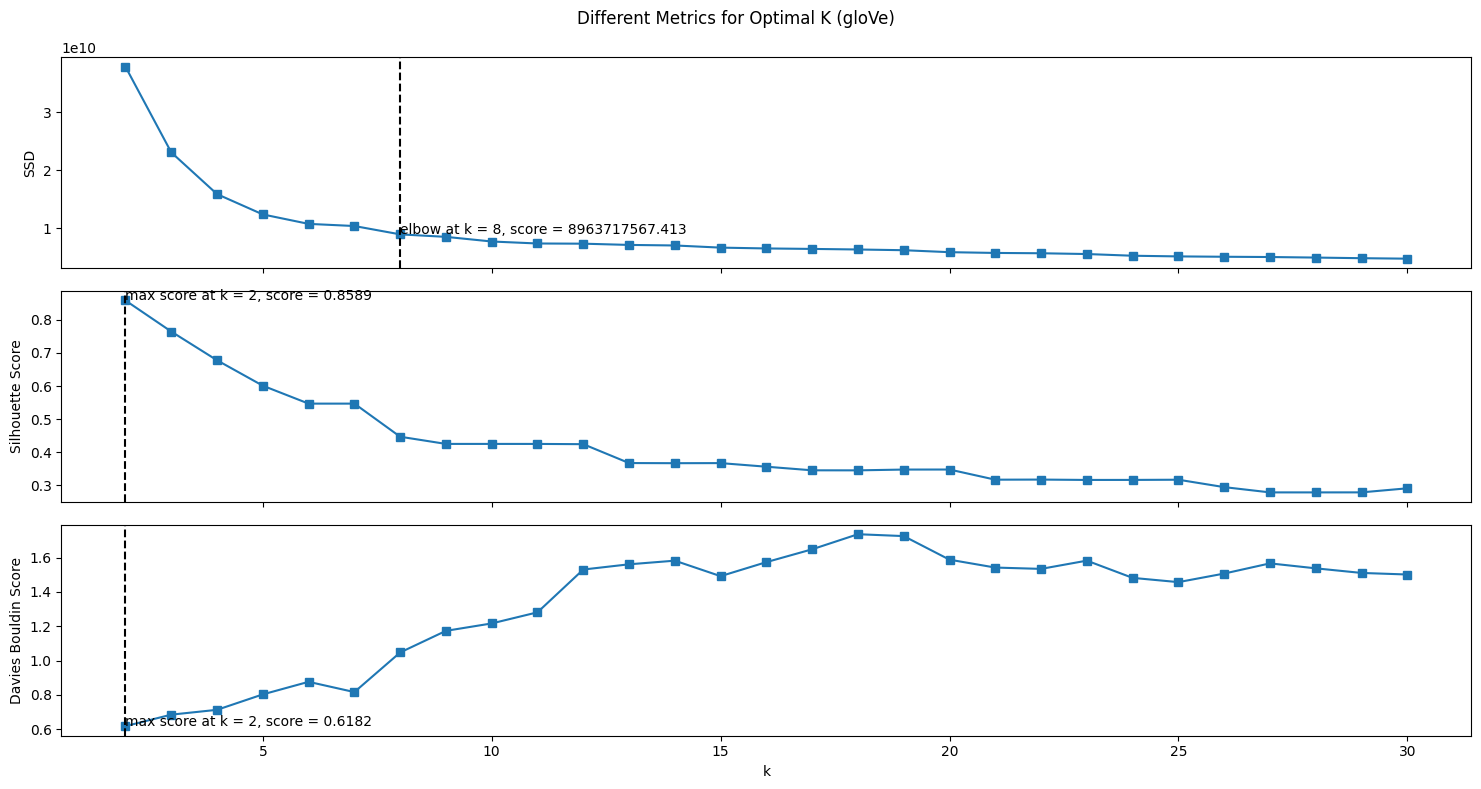

In [33]:
# Display plots for gloVe
metrics_df = create_models(glove_emb)
display_k_plots(metrics_df, 'gloVe')

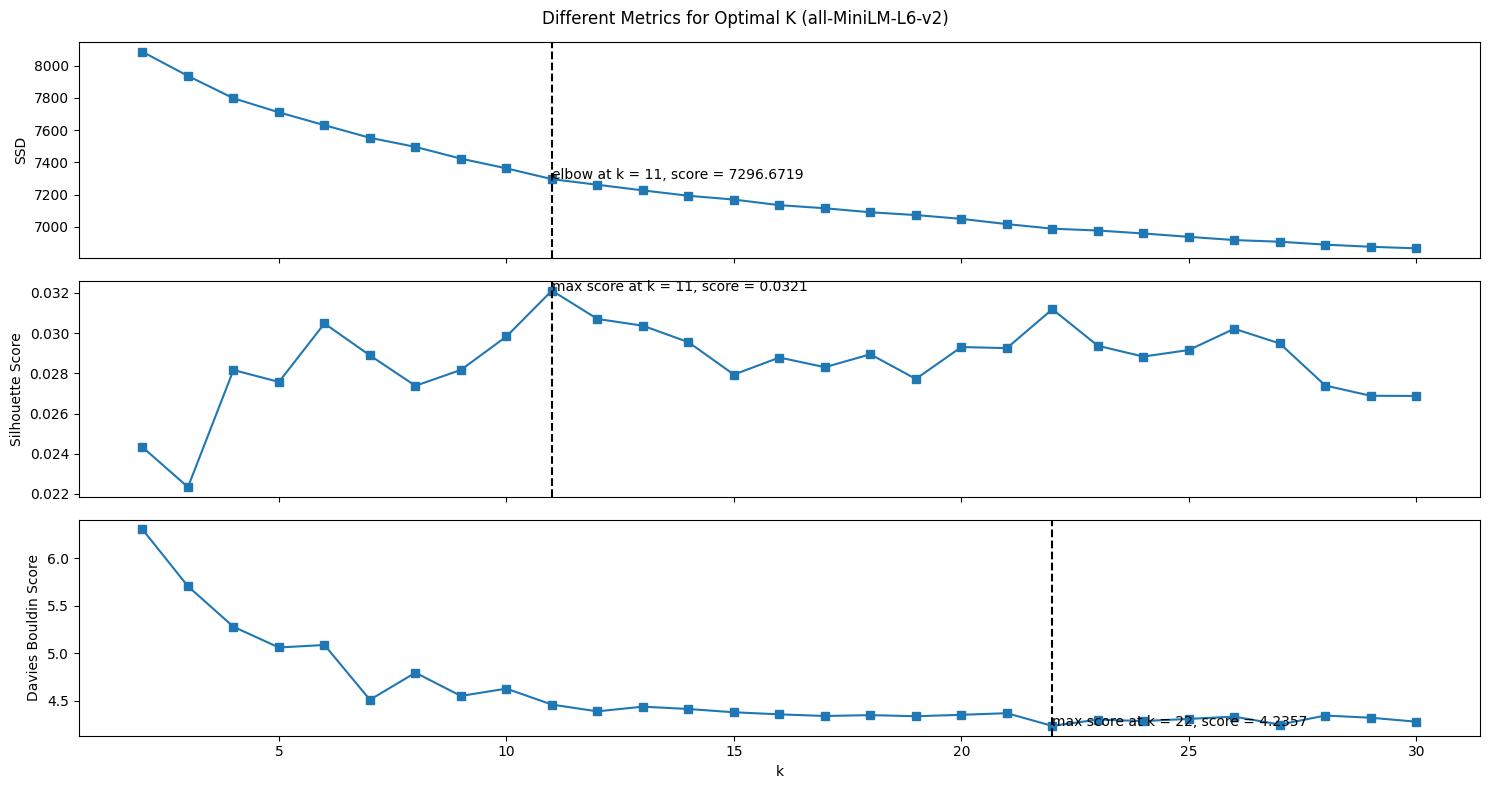

In [34]:
# Display plots for all-MiniLM-L6-v2
metrics_df = create_models(mini_emb)
display_k_plots(metrics_df, 'all-MiniLM-L6-v2')

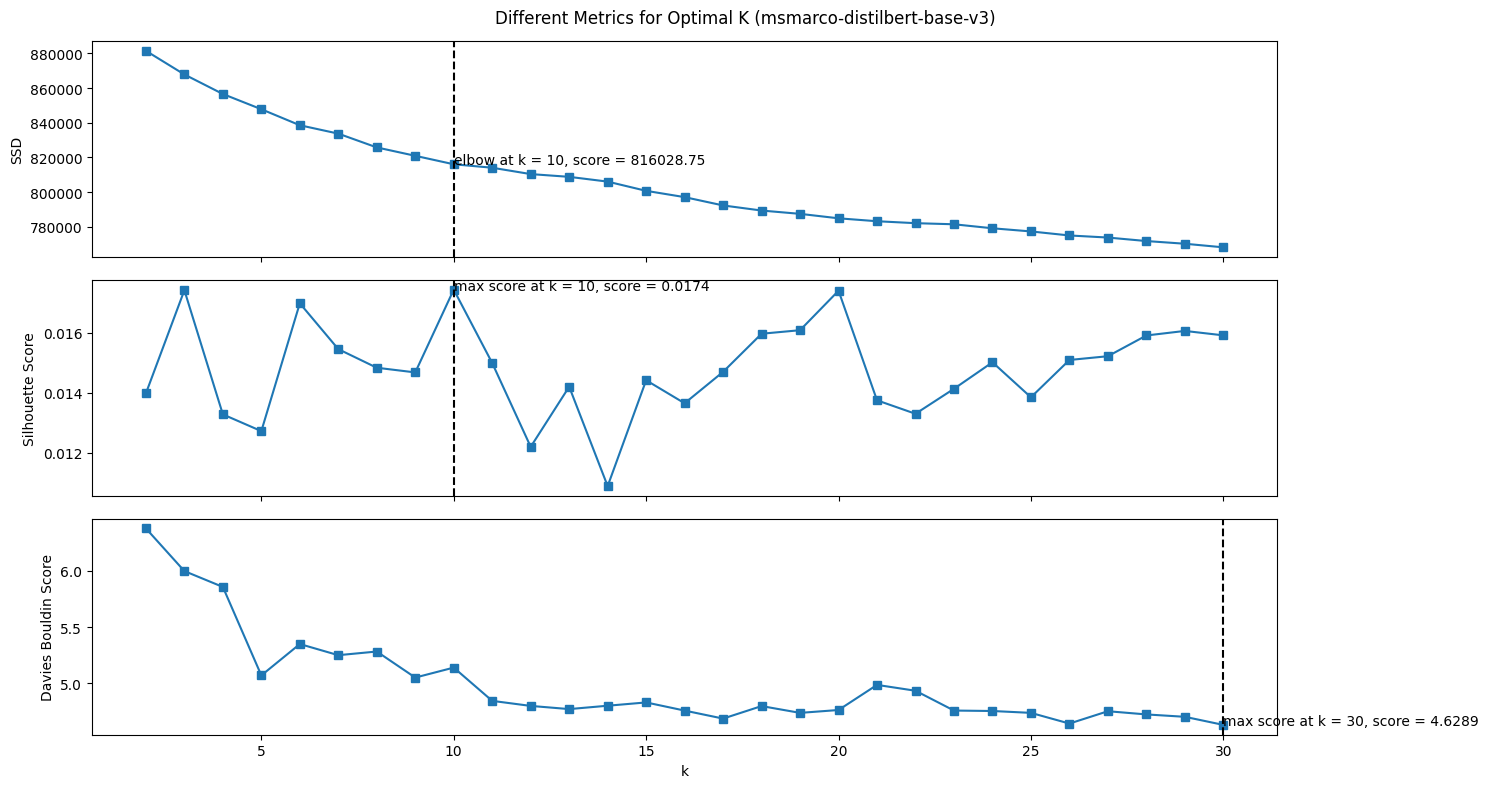

In [35]:
# Display plots for msmarco-distilbert-base-v3
metrics_df = create_models(bert_emb)
display_k_plots(metrics_df, 'msmarco-distilbert-base-v3')

#### Find optimal feature extracting method

### DBSCAN

### Latent Dirichlet Allocation (LDA)

## Evaluation and Interpretation

### Visualize Clusters

In [ ]:
#  t-SNE, UMAP, PCA

### Analyse Clusters

## End